In [1]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from pathlib import Path

from time import sleep

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.utils import shuffle

from importlib import reload
import sentinel_utils
import keras_model_creator

import tensorflow as tf

from data_generator import DataGenerator

In [2]:
%load_ext tensorboard

In [3]:
sentinel_bands = [f'B{x}' for x in range(2, 9)] + ['B8A', 'B11', 'B12']
soilgrids_band = ['bdod', 'cec', 'cfvo', 'clay', 'nitrogen', 'ocd',
                  'ocs', 'phh2o', 'sand', 'silt', 'soc']
all_bands = sentinel_bands + ['Elevation'] + soilgrids_band
selected_sentinel = ['B2', 'B5', 'B8', 'B12']
selected_bands = ['B2']
bands = [all_bands.index(b) for b in selected_bands]
bands

[0]

In [4]:
reload(sentinel_utils)

shards_dir = Path.home().joinpath('sentinel_data', 'shards')

sentinel_shards = []
# seasons = ['03', '06', '09', '12']
seasons = ['06']
year = 2017
for s in seasons:
    path_list = list(shards_dir.joinpath(f'features_{year}{s}').glob('feature_*.npy'))
    sentinel_shards.extend(path_list)
    
sample_shards = 40000
utils = sentinel_utils.SentinelUtils(
    seasons,
    shuffle(sentinel_shards, random_state=42)[:sample_shards],
    min_occurrences=20000, overwrite_existing=False
)
shard_ids = utils.selected_classes.index

In [5]:
opt = tf.keras.optimizers.Adam(
    learning_rate=1e-4,
    beta_1=0.9,
    beta_2=0.999,
)

loss = 'binary_crossentropy'
batch_size = 64
base_filters = 32
tag = f'conv3d'

model_dir = Path('models',
    f'{loss}-{len(shard_ids)}-{utils.selected_classes.shape[1]}'
    f'-{len(bands)}-{"_".join(seasons)}-{batch_size}'
    f'-{base_filters}-{opt.name}-{tag}'
)
model_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir = str(model_dir.joinpath('tensorboard_logs'))
model_dir

PosixPath('models/binary_crossentropy-237212-7-1-06-64-32-adam-conv3d-lr0.0001')

In [6]:
# %tensorboard --logdir=$tensorboard_dir

In [ ]:
reload(keras_model_creator)
params = dict(
    utils=utils,
    shards_dir=shards_dir,
    shard_ids=shard_ids,
    model_dir=model_dir,
    seasons=seasons,
    year=year,
    bands=bands,
    loss=loss,
    batch_size=batch_size,
    base_filters=base_filters,
    opt=opt,
    dropout=0.2,
    epochs=10,
    overwrite=True
)

model, testing_generator = keras_model_creator.KerasModelCreator(**params).run()

Epoch 1/10


I0000 00:00:1721909881.128620    4180 service.cc:145] XLA service 0x7f6cf4002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721909881.128664    4180 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9


In [ ]:
# for eval_year in [2017, 2020, 2021, 2022, 2023]:
#     params['year'] = eval_year
#     eval_generator = DataGenerator(shard_ids, shuffle=False, **params)
#     preds_path = model_dir.joinpath(f"preds_{params['year']}.npy")
#     if preds_path.is_file():
#         y_pred = np.load(preds_path)
#     else:
#         y_pred = model.predict(x=eval_generator, verbose=1)
#         np.save(preds_path, y_pred)

#     y_true = utils.selected_classes.iloc[:y_pred.shape[0]].to_numpy()
#     cm = confusion_matrix(y_true.flatten(), (y_pred > 0.5).flatten().astype(int))
#     plot = ConfusionMatrixDisplay(confusion_matrix=cm).plot()
#     display(plot)

In [ ]:
# import matplotlib.pyplot as plt

# class_names = utils.selected_classes.columns

# f, axes = plt.subplots(4, 2, figsize=(25, 30))
# axes = axes.ravel()
# for label in range(y_true.shape[1]):
#     cm = confusion_matrix(y_true[..., label].astype(int), (y_pred[..., label] > 0.5).astype(int))
#     disp = ConfusionMatrixDisplay(cm)
#     disp.plot(ax=axes[label], values_format='.4g')
#     disp.ax_.set_title(f'{class_names[label]}')
#     if label < 25:
#         disp.ax_.set_xlabel('')
#     if label % 5 != 0:
#         disp.ax_.set_ylabel('')
#     disp.im_.colorbar.remove()

# plt.subplots_adjust(wspace=0.2, hspace=0.001)
# f.colorbar(disp.im_, ax=axes)
# plt.show()


In [ ]:
# import tensorflow
# tensorflow.keras.utils.plot_model(model, show_shapes=True)
# model.summary()

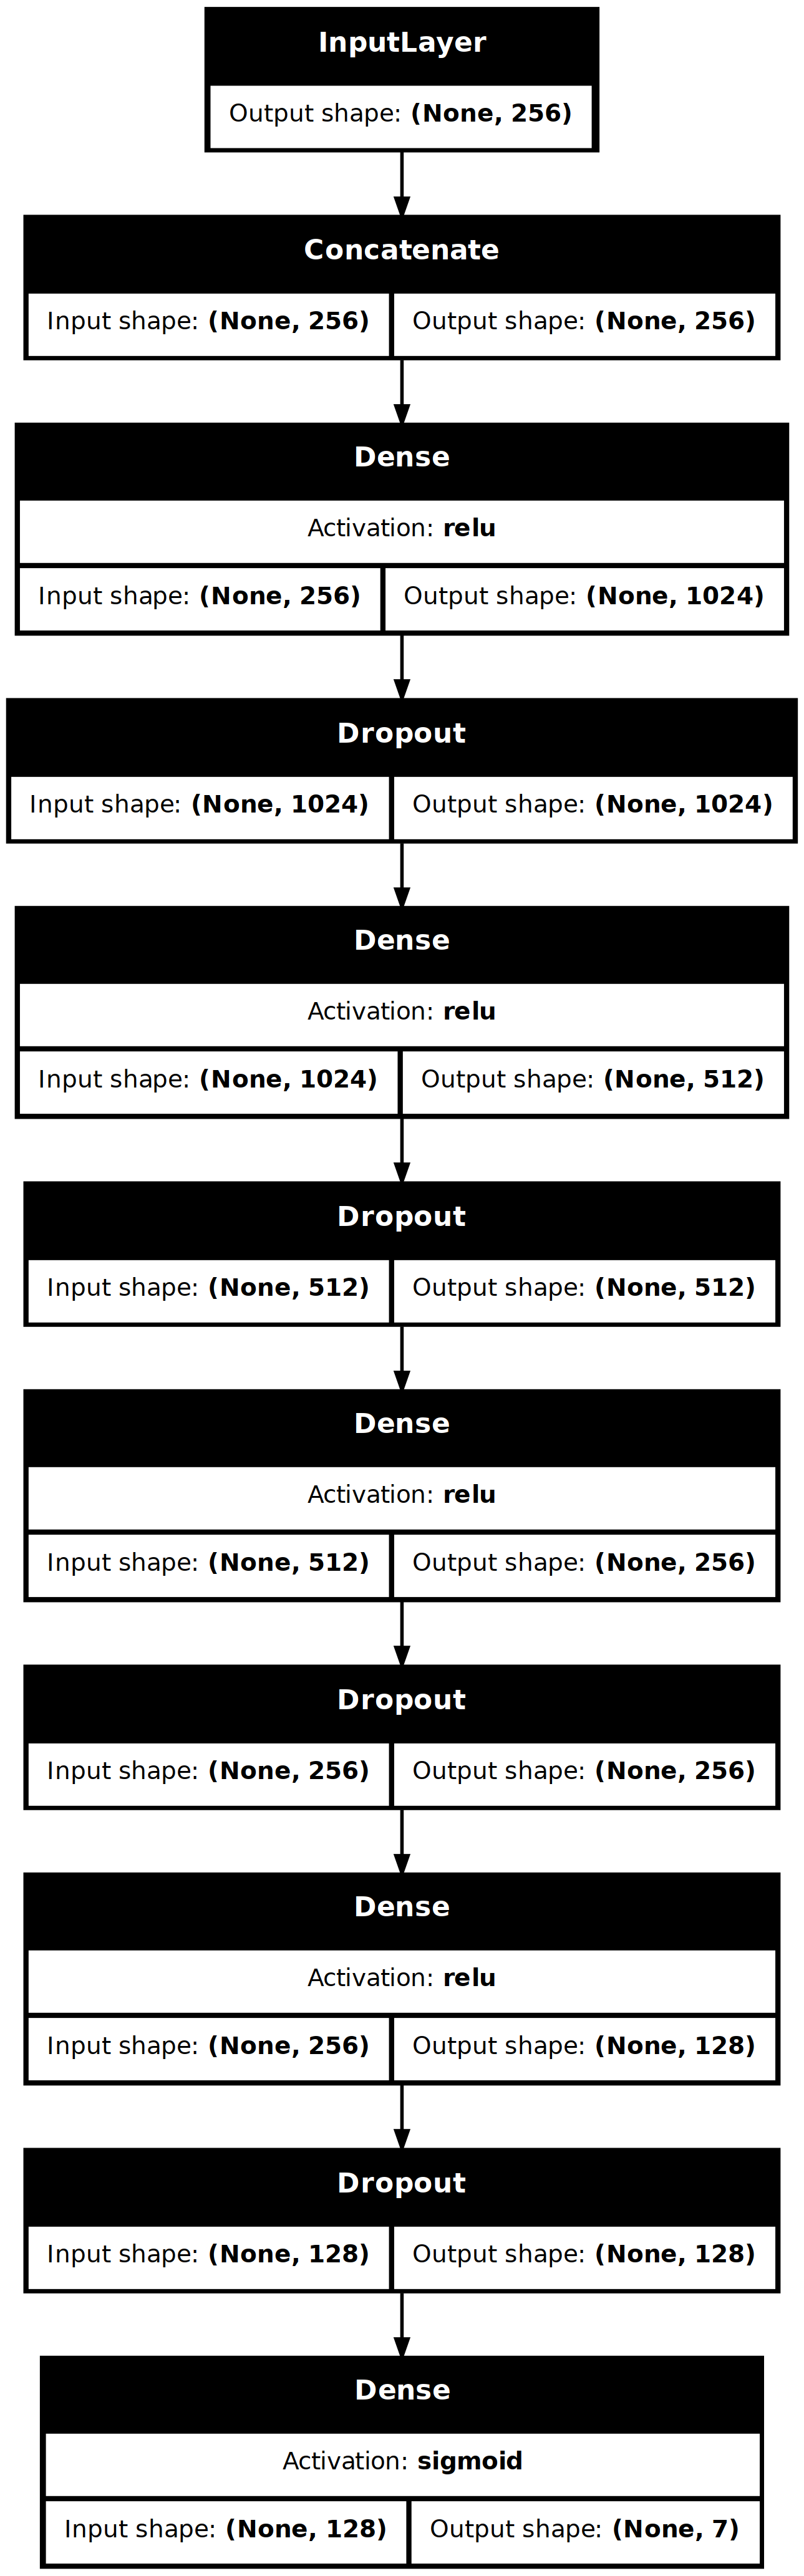

In [18]:
# import tensorflow
# tensorflow.keras.utils.plot_model(
#     model, to_file=model_dir.joinpath('model.png'),
#     show_shapes=True, show_layer_activations=True,
# )

In [ ]:
# import tensorflow.keras.backend as K
# K.eval(model.optimizer.learning_rate)

In [ ]:
# import plotly.express as px

# class_names = utils.selected_classes.columns
# indices = utils.selected_classes.index

# preds_path = model_dir.joinpath(f'preds_2020.npy')
# y_prev = np.load(preds_path)

# weather_prev = pd.read_csv(Path('weather_data', 'era5_2020.csv'))
# eval_years = [2021, 2022, 2023]
# corrs = []

# for eval_year in eval_years:
#     preds_path = model_dir.joinpath(f'preds_{eval_year}.npy')
#     y_pred = np.load(preds_path)
#     y_diff = pd.DataFrame(y_pred - y_prev, columns=class_names)
    
#     weather = pd.read_csv(Path('weather_data', f'era5_{eval_year}.csv'))
#     weather_diff = ((weather - weather_prev)
#                     .loc[indices]
#                     .iloc[:y_pred.shape[0]]
#                     .iloc[y_diff.index])
    
#     corr = y_diff.join(weather_diff).corr(method='pearson').round(2)
#     corrs.append(corr)

#     y_prev = y_pred
#     weather_prev = weather

# fig = px.imshow(
#     np.array(corrs),
#     animation_frame=0,
#     labels=dict(color="Corr coef"),
#     x=corrs[0].index,
#     y=corrs[0].columns,
#     title='Annual correlation heatmap',
#     text_auto=True, aspect='auto', zmin=0, height=500
# )
# fig.layout.sliders[0]['currentvalue']['prefix'] = ''
# for year, step in zip(eval_years, fig.layout.sliders[0].steps):
#     step.label = str(year)

# fig